In [2]:
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime
from IPython.display import display, HTML
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# SMALLER DATASET JUST FOR TESTING
# df=pd.read_csv('ura_1_5.csv',skiprows=1)
# df=df[:-6] #Get rid of tail non-data description
# display(df.tail(2))

# Large Dataset
df_1_5=pd.read_csv('ura_1_5.csv',skiprows=1)
df_1_5=df_1_5[:-6] #Get rid of tail non-data description
# display(df_1_5.tail(2))

df_6_10=pd.read_csv('ura_6_10.csv',skiprows=1)
df_6_10=df_6_10[:-6] #Get rid of tail non-data description
# display(df_6_10.tail(2))

df_11_15=pd.read_csv('ura_11_15.csv',skiprows=1)
df_11_15=df_11_15[:-6] #Get rid of tail non-data description
# display(df_11_15.tail(2))

df_16_20=pd.read_csv('ura_16_20.csv',skiprows=1)
df_16_20=df_16_20[:-6] #Get rid of tail non-data description
# display(df_16_20.tail(2))

df_21_26=pd.read_csv('ura_21_26.csv',skiprows=1)
df_21_26=df_21_26[:-6] #Get rid of tail non-data description
# display(df_21_26.tail(2))

df_27_28=pd.read_csv('ura_27_28.csv',skiprows=1)
df_27_28=df_27_28[:-6] #Get rid of tail non-data description
# display(df_27_28.tail(2))

print("====================All URA Dataframe=======================")
df = pd.concat([df_1_5, df_6_10,df_11_15,df_16_20,df_21_26,df_27_28], ignore_index=True)
display(df.tail(2))

df_dict=pd.read_csv('property_project.csv')
df_dict=df_dict[['address','lat','long']]
df_dict=df_dict.set_index('address').to_dict()
df_dict['lat']['JI XIANG COURT']

dates_dict={
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun":6,
    "Jul":7,
    "Aug":8,
    "Sep":9,
    "Oct":10,
    "Nov":11,
    "Dec":12    
}

# Preprocessing
# -Converting Floor Area(1400 to 1500 -> 1450)
# -Monthly rental/ sqft> Monthly rental Psf
# -Building/Project Name , District -> lat, long
# -Lease Commencement Date -> date
def g(x):
    if(x=='ANGULLIA PARK RESIDENCES @ ORCHARD'):
        return 'ANGULLIA PARK RESIDENCES@ORCHARD'
    return x
df['Building/Project Name'] = df['Building/Project Name'].apply(g)
    
    
def f(x):
    try:
        return sum([int(item) for item in str(x).split(' to ')])/2
    except:
        return 0
df['Floor Area (sq ft)'] = df['Floor Area (sq ft)'].apply(f)
df['Monthly Rent/ psf']=df['Monthly Gross Rent($)']/df['Floor Area (sq ft)']
df['lat']=df['Building/Project Name'].apply(lambda x:df_dict['lat'][x])
df['long']=df['Building/Project Name'].apply(lambda x:df_dict['long'][x])
def g(x):
    m,y=x.split('-')
    return pd.Timestamp(int(y),dates_dict[m],1).toordinal()
df['Lease Commencement Date']=df['Lease Commencement Date'].apply(g).astype(float)
# # Remove missing bedroom data
df['No. of Bedroom(for Non-Landed Only)']=df['No. of Bedroom(for Non-Landed Only)'].replace('na*',np.NaN)
df=df.dropna()
df = df.drop(df[df["Floor Area (sq ft)"]<50].index)

# Rename for Bed Room
df.rename(columns={'No. of Bedroom(for Non-Landed Only)':'no_bedroom'}, inplace=True)# Rename Bed Room
df=df.rename(index=str, columns={"Building/Project Name":"project","Street Name":"street_name","Type":"type","Monthly Gross Rent($)": "monthly_gross_rent", "Monthly Rent/ psf": "monthly_rent_psf","Postal District":"district_f","lat": "lat","long": "long","no_bedroom": "no_bedroom","Floor Area (sq ft)": "floor_area","Lease Commencement Date": "date" })
df_c=df
# One Hot Encoding for district
df['district']=df['district_f'].apply(lambda x:(str(int(x))))
df = pd.concat([df,pd.get_dummies(df['district'], prefix='district')],axis=1)
display(df.head(1))

# One Hot Encoding for project
df = pd.concat([df,pd.get_dummies(df['project'], prefix='project')],axis=1)
display(df.head(1))


df['no_bedroom']=df['no_bedroom'].astype(float)
df['floor_area']=df['floor_area'].astype(float)


# KN : One Hot Encoding for district, One Hot Encoding for bedrooms
# KN : Refactor code to display data Prepocessing Step

print("====================Old Preprocessed Dataframe (name: df ->liyang has some dependencies #bedroom counts)=======================")
display(df.tail(3))

print("====================Preprocessed Dataframe (name: df_prep)=======================")
# # consolidaiton of Data
df_prep=df.drop(['S/N', 'project','street_name','district','type','date'], axis=1)
display(df_prep.tail(3))

====================All URA Dataframe=======================


,S/N,Building/Project Name,Street Name,Postal District,Type,No. of Bedroom(for Non-Landed Only),Monthly Gross Rent($),Floor Area (sq ft),Lease Commencement Date
223714,4680,H2O RESIDENCES,FERNVALE LINK,28.0,Non-landed Properties,3,2700.0,1100 to 1200,Nov-2015
223715,4681,H2O RESIDENCES,FERNVALE LINK,28.0,Non-landed Properties,3,2500.0,1100 to 1200,Nov-2015


,S/N,project,street_name,district_f,type,no_bedroom,monthly_gross_rent,floor_area,date,monthly_rent_psf,...,district_26,district_27,district_28,district_3,district_4,district_5,district_6,district_7,district_8,district_9
1,2,HIGHLINE RESIDENCES,KIM TIAN ROAD,3.0,Non-landed Properties,3,5000.0,950.0,736968.0,5.263158,...,0,0,0,1,0,0,0,0,0,0


,S/N,project,street_name,district_f,type,no_bedroom,monthly_gross_rent,floor_area,date,monthly_rent_psf,...,project_WOODSVILLE MANSIONS,project_WOOLLERTON PARK,project_WORTHINGTON,project_YEWTEE RESIDENCES,project_YGK GARDEN,project_YISHUN EMERALD,project_YISHUN SAPPHIRE,project_YONG AN PARK,project_ZEDGE,project_ZENITH
1,2,HIGHLINE RESIDENCES,KIM TIAN ROAD,3.0,Non-landed Properties,3,5000.0,950.0,736968.0,5.263158,...,0,0,0,0,0,0,0,0,0,0


====================Old Preprocessed Dataframe (name: df ->liyang has some dependencies #bedroom counts)=======================


,S/N,project,street_name,district_f,type,no_bedroom,monthly_gross_rent,floor_area,date,monthly_rent_psf,...,project_WOODSVILLE MANSIONS,project_WOOLLERTON PARK,project_WORTHINGTON,project_YEWTEE RESIDENCES,project_YGK GARDEN,project_YISHUN EMERALD,project_YISHUN SAPPHIRE,project_YONG AN PARK,project_ZEDGE,project_ZENITH
223713,4679,EIGHT COURTYARDS,CANBERRA DRIVE,27.0,Non-landed Properties,2.0,2400.0,850.0,735903.0,2.823529,...,0,0,0,0,0,0,0,0,0,0
223714,4680,H2O RESIDENCES,FERNVALE LINK,28.0,Non-landed Properties,3.0,2700.0,1150.0,735903.0,2.347826,...,0,0,0,0,0,0,0,0,0,0
223715,4681,H2O RESIDENCES,FERNVALE LINK,28.0,Non-landed Properties,3.0,2500.0,1150.0,735903.0,2.173913,...,0,0,0,0,0,0,0,0,0,0


====================Preprocessed Dataframe (name: df_prep)=======================


,district_f,no_bedroom,monthly_gross_rent,floor_area,monthly_rent_psf,lat,long,district_1,district_10,district_11,...,project_WOODSVILLE MANSIONS,project_WOOLLERTON PARK,project_WORTHINGTON,project_YEWTEE RESIDENCES,project_YGK GARDEN,project_YISHUN EMERALD,project_YISHUN SAPPHIRE,project_YONG AN PARK,project_ZEDGE,project_ZENITH
223713,27.0,2.0,2400.0,850.0,2.823529,1.438604,103.831283,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223714,28.0,3.0,2700.0,1150.0,2.347826,1.392766,103.879232,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223715,28.0,3.0,2500.0,1150.0,2.173913,1.392766,103.879232,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Linear Model
X=np.array(df_prep.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df_prep['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)
clf= LinearRegression()
clf.fit(X_train, y_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
accuracy=clf.score(X_test,y_test)
clf,accuracy

# print(X_test.shape)
X_test_normalized = preprocessing.normalize(X_test)
y_predict_normalized = clf.predict(X_test_normalized)
y_predict_normalized = pd.DataFrame(y_predict_normalized)
# y_predict = clf.predict(X_test)
# y_predict = pd.DataFrame(y_predict)
# print(y_test.shape)
y_test_normalized = preprocessing.scale(y_test)
y_test_normalized = pd.DataFrame(y_test_normalized)
# y_test = pd.DataFrame(y_test)

print("----Linear Regression----")

squared_error = (y_predict_normalized - y_test_normalized)**(2)
# squared_error = (y_predict - y_test)**(2)
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

# from sklearn.metrics import mean_squared_error, r2_score
#print("Mean squared error: %.2f"
#      % mean_squared_error(y_test, y_predict))

(158500, 1978)
(39625, 1978)
(158500,)
(39625,)


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 -7.638595143248174e+24)

----Linear Regression----
0    7.544025e+09
dtype: float64


In [ ]:
# Linear Model
X=np.array(df_prep.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df_prep['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)
clf= LinearRegression()
clf.fit(X_train, y_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
accuracy=clf.score(X_test,y_test)
clf,accuracy

# print(X_test.shape)
X_test_normalized = preprocessing.normalize(X_test)
y_predict_normalized = clf.predict(X_test_normalized)
y_predict_normalized = pd.DataFrame(y_predict_normalized)
# y_predict = clf.predict(X_test)
# y_predict = pd.DataFrame(y_predict)
# print(y_test.shape)
y_test_normalized = preprocessing.scale(y_test)
y_test_normalized = pd.DataFrame(y_test_normalized)
# y_test = pd.DataFrame(y_test)

print("----Linear Regression Normalised----")

squared_error = (y_predict_normalized - y_test_normalized)**(2)
# squared_error = (y_predict - y_test)**(2)
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

# from sklearn.metrics import mean_squared_error, r2_score
#print("Mean squared error: %.2f"
#      % mean_squared_error(y_test, y_predict))

In [3]:
# Linear Model
X=np.array(df_prep.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df_prep['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)
clf= LinearRegression()
clf.fit(X_train, y_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
accuracy=clf.score(X_test,y_test)
clf,accuracy

y_predict = clf.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

print("----Linear Regression ----")

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

# from sklearn.metrics import mean_squared_error, r2_score
#print("Mean squared error: %.2f"
#      % mean_squared_error(y_test, y_predict))

(158500, 1978)
(39625, 1978)
(158500,)
(39625,)
----Linear Regression ----
0    3.512038e+12
dtype: float64


In [13]:
# Linear Model
bedroom=df1
X=np.array(bedroom.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(bedroom['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)
clf= LinearRegression()
clf.fit(X_train, y_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
accuracy=clf.score(X_test,y_test)
clf,accuracy

y_predict = clf.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

print("----Linear Regression Training for 1 Bedroom ----")

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

# from sklearn.metrics import mean_squared_error, r2_score
#print("Mean squared error: %.2f"
#      % mean_squared_error(y_test, y_predict))

(33205, 1978)
(8302, 1978)
(33205,)
(8302,)
----Linear Regression Training for 1 Bedroom ----
0    1.445912e+13
dtype: float64


In [14]:
# Linear Model
bedroom=df2
X=np.array(bedroom.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(bedroom['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)
clf= LinearRegression()
clf.fit(X_train, y_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
accuracy=clf.score(X_test,y_test)
clf,accuracy

y_predict = clf.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

print("----Linear Regression Training for 2 Bedroom ----")

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)


(54850, 1978)
(13713, 1978)
(54850,)
(13713,)
----Linear Regression Training for 2 Bedroom ----
0    1.659924e+13
dtype: float64


In [18]:
# Linear Model
bedroom=df3
X=np.array(bedroom.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(bedroom['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)
clf= LinearRegression()
clf.fit(X_train, y_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
accuracy=clf.score(X_test,y_test)
clf,accuracy

y_predict = clf.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

print("----Linear Regression Training for 3 Bedroom ----")

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)


(57994, 1978)
(14499, 1978)
(57994,)
(14499,)
----Linear Regression Training for 3 Bedroom ----
0    1.245078e+13
dtype: float64


In [16]:
# Linear Model
bedroom=df4
X=np.array(bedroom.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(bedroom['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)
clf= LinearRegression()
clf.fit(X_train, y_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
accuracy=clf.score(X_test,y_test)
clf,accuracy

y_predict = clf.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

print("----Linear Regression Training for 4 Bedroom ----")

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)


(12212, 1978)
(3054, 1978)
(12212,)
(3054,)
----Linear Regression Training for 4 Bedroom ----
0    1.753600e+13
dtype: float64


In [17]:
# Linear Model
bedroom=df5
X=np.array(bedroom.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(bedroom['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)
clf= LinearRegression()
clf.fit(X_train, y_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
accuracy=clf.score(X_test,y_test)
clf,accuracy

y_predict = clf.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

print("----Linear Regression Training for 5 Bedroom ----")

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)


(224, 1978)
(56, 1978)
(224,)
(56,)
----Linear Regression Training for 5 Bedroom ----
0    9.755761e+13
dtype: float64


In [7]:
print("--------SVR Training for 1 Bedroom--------")
print("SVM Train Score: 0.823560571547394")
print("SVM Test Score: 0.7975827106641445")
print("0    0.543937")
print("dtype: float64")

print("\n--------SVR Training for 2 Bedroom--------")
print("SVM Train Score: 0.8541603065742962")
print("SVM Test Score: 0.8487974179311276")
print("0    0.407738")
print("dtype: float64")

--------SVR Training for 1 Bedroom--------
SVM Train Score: 0.823560571547394
SVM Test Score: 0.7975827106641445
0    0.543937
dtype: float64

--------SVR Training for 2 Bedroom--------
SVM Train Score: 0.8541603065742962
SVM Test Score: 0.8487974179311276
0    0.407738
dtype: float64


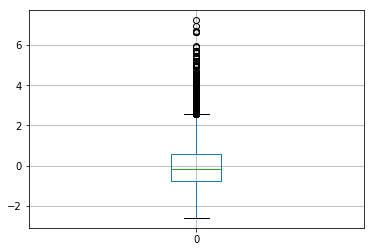

In [6]:
# fig, ax = plt.subplots() 
# print(y_test_normalized.shape)
# print(y_predict_normalized.shape)
# ax.boxplot([y_predict_normalized,y_test_normalized]) 
y_test_normalized.boxplot()

In [11]:
# Li Yang : Ridge Regression Model (split into different bedroom)
df1 = df_prep[(df.no_bedroom>0.9)&(df.no_bedroom <1.1)]
display(df1.tail(3))

df2 = df_prep[(df.no_bedroom>1.9)&(df.no_bedroom <2.1)]
display(df2.tail(3))

df3 = df_prep[(df.no_bedroom>2.9)&(df.no_bedroom <3.1)]
display(df3.tail(3))

df4 = df_prep[(df.no_bedroom>3.9)&(df.no_bedroom <4.1)]
display(df4.tail(3))

df5 = df_prep[(df.no_bedroom>4.9)&(df.no_bedroom <5.1)]
display(df5.tail(3))

,district_f,no_bedroom,monthly_gross_rent,floor_area,monthly_rent_psf,lat,long,district_1,district_10,district_11,...,project_WOODSVILLE MANSIONS,project_WOOLLERTON PARK,project_WORTHINGTON,project_YEWTEE RESIDENCES,project_YGK GARDEN,project_YISHUN EMERALD,project_YISHUN SAPPHIRE,project_YONG AN PARK,project_ZEDGE,project_ZENITH
223675,28.0,1.0,1800.0,550.0,3.272727,1.386126,103.869516,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223685,28.0,1.0,2100.0,650.0,3.230769,1.386980,103.868809,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223698,28.0,1.0,1900.0,650.0,2.923077,1.386980,103.868809,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,district_f,no_bedroom,monthly_gross_rent,floor_area,monthly_rent_psf,lat,long,district_1,district_10,district_11,...,project_WOODSVILLE MANSIONS,project_WOOLLERTON PARK,project_WORTHINGTON,project_YEWTEE RESIDENCES,project_YGK GARDEN,project_YISHUN EMERALD,project_YISHUN SAPPHIRE,project_YONG AN PARK,project_ZEDGE,project_ZENITH
223707,27.0,2.0,2350.0,950.0,2.473684,1.410992,103.832387,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223710,28.0,2.0,2200.0,850.0,2.588235,1.392766,103.879232,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223713,27.0,2.0,2400.0,850.0,2.823529,1.438604,103.831283,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,district_f,no_bedroom,monthly_gross_rent,floor_area,monthly_rent_psf,lat,long,district_1,district_10,district_11,...,project_WOODSVILLE MANSIONS,project_WOOLLERTON PARK,project_WORTHINGTON,project_YEWTEE RESIDENCES,project_YGK GARDEN,project_YISHUN EMERALD,project_YISHUN SAPPHIRE,project_YONG AN PARK,project_ZEDGE,project_ZENITH
223708,27.0,3.0,2600.0,950.0,2.736842,1.438604,103.831283,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223714,28.0,3.0,2700.0,1150.0,2.347826,1.392766,103.879232,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223715,28.0,3.0,2500.0,1150.0,2.173913,1.392766,103.879232,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,district_f,no_bedroom,monthly_gross_rent,floor_area,monthly_rent_psf,lat,long,district_1,district_10,district_11,...,project_WOODSVILLE MANSIONS,project_WOOLLERTON PARK,project_WORTHINGTON,project_YEWTEE RESIDENCES,project_YGK GARDEN,project_YISHUN EMERALD,project_YISHUN SAPPHIRE,project_YONG AN PARK,project_ZEDGE,project_ZENITH
223684,27.0,4.0,3300.0,1450.0,2.275862,1.424878,103.824647,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223709,27.0,4.0,3280.0,1550.0,2.116129,1.412497,103.835257,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223712,27.0,4.0,3800.0,1550.0,2.451613,1.410992,103.832387,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,district_f,no_bedroom,monthly_gross_rent,floor_area,monthly_rent_psf,lat,long,district_1,district_10,district_11,...,project_WOODSVILLE MANSIONS,project_WOOLLERTON PARK,project_WORTHINGTON,project_YEWTEE RESIDENCES,project_YGK GARDEN,project_YISHUN EMERALD,project_YISHUN SAPPHIRE,project_YONG AN PARK,project_ZEDGE,project_ZENITH
221591,27.0,5.0,4000.0,1350.0,2.962963,1.280688,103.849207,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222816,27.0,5.0,3500.0,1350.0,2.592593,1.280688,103.849207,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223041,27.0,5.0,4200.0,1350.0,3.111111,1.280688,103.849207,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X=np.array(df1.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df1['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2,random_state=6)
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
print("----Ridge Regression Training for 1 Bedroom----")
print("ridge regression train score low alpha:", Ridge_train_score) 
print("ridge regression test score low alpha:", Ridge_test_score)

y_predict = rr.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

----Ridge Regression Training for 1 Bedroom----
ridge regression train score low alpha: 0.8362155603599057
ridge regression test score low alpha: 0.8008280491037222
0    0.539559
dtype: float64


In [9]:
X=np.array(df2.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df2['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2,random_state=6)
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
print("----Ridge Regression Training for 2 Bedroom----")
print("ridge regression train score low alpha:", Ridge_train_score) 
print("ridge regression test score low alpha:", Ridge_test_score)
y_predict = rr.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

----Ridge Regression Training for 2 Bedroom----
ridge regression train score low alpha: 0.8674433906988741
ridge regression test score low alpha: 0.8632316951033114
0    0.387788
dtype: float64


In [10]:
X=np.array(df3.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df3['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2,random_state=8)
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
print("----Ridge Regression Training for 3 Bedroom----")
print("ridge regression train score low alpha:", Ridge_train_score) 
print("ridge regression test score low alpha:", Ridge_test_score)

y_predict = rr.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

----Ridge Regression Training for 3 Bedroom----
ridge regression train score low alpha: 0.8626541941953046
ridge regression test score low alpha: 0.8538274627108565
0    0.324305
dtype: float64


In [11]:
X=np.array(df4.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df4['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2,random_state=8)
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
print("----Ridge Regression Training for 4 Bedroom----")
print("ridge regression train score low alpha:", Ridge_train_score) 
print("ridge regression test score low alpha:", Ridge_test_score)

y_predict = rr.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

----Ridge Regression Training for 4 Bedroom----
ridge regression train score low alpha: 0.8595906176553494
ridge regression test score low alpha: 0.8430032787007737
0    0.379531
dtype: float64


In [12]:
X=np.array(df5.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df5['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2,random_state=8)
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
print("----Ridge Regression Training for 5 Bedroom----")
print("ridge regression train score low alpha:", Ridge_train_score) 
print("ridge regression test score low alpha:", Ridge_test_score)

y_predict = rr.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

----Ridge Regression Training for 5 Bedroom----
ridge regression train score low alpha: 0.9106760476542627
ridge regression test score low alpha: 0.8164825744630229
0    0.527187
dtype: float64


In [13]:
X=np.array(df_prep.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df_prep['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2,random_state=8)
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
print("----Ridge Regression Training----")
print("ridge regression train score low alpha:", Ridge_train_score) 
print("ridge regression test score low alpha:", Ridge_test_score)

y_predict = rr.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

----Ridge Regression Training for 5 Bedroom----
ridge regression train score low alpha: 0.8389762355269912
ridge regression test score low alpha: 0.8362928943023967
0    0.468583
dtype: float64


In [20]:
print("----Ridge Regression Training----")
print("ridge regression train score low alpha: 0.8389762355269912")
print("ridge regression test score low alpha: 0.8362928943023967")
print("0    0.468583")
print("dtype: float64")

----Ridge Regression Training----
ridge regression train score low alpha: 0.8389762355269912
ridge regression test score low alpha: 0.8362928943023967
0    0.468583
dtype: float64


In [ ]:
#For 1 Bedroom
X=np.array(df1.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df1['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,random_state=6) 
svclassifier = SVR(kernel="rbf")  
svclassifier.fit(X_train, y_train)  
svm_train_score = svclassifier.score(X_train,y_train)
svm_test_score = svclassifier.score(X_test, y_test)
print("----SVM Training Results----")
print("SVM Train Score:", svm_train_score) 
print("SVM Test Score:", svm_test_score)

y_predict = svclassifier.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

In [ ]:
# SVM for 2 Bedroom
X=np.array(df2.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df2['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,random_state=6) 
svclassifier = SVR(kernel="rbf")  
svclassifier.fit(X_train, y_train)  
svm_train_score = svclassifier.score(X_train,y_train)
svm_test_score = svclassifier.score(X_test, y_test)
print("----SVM Training Results----")
print("SVM Train Score:", svm_train_score) 
print("SVM Test Score:", svm_test_score)

y_predict = svclassifier.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

In [ ]:
# SVM for 3 Bedroom
X=np.array(df3.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df3['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,random_state=6) 
svclassifier = SVR(kernel="rbf")  
svclassifier.fit(X_train, y_train)  
svm_train_score = svclassifier.score(X_train,y_train)
svm_test_score = svclassifier.score(X_test, y_test)
print("----SVM Training Results----")
print("SVM Train Score:", svm_train_score) 
print("SVM Test Score:", svm_test_score)

y_predict = svclassifier.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

In [ ]:
# SVM for 4 Bedroom
X=np.array(df4.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df4['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,random_state=6) 
svclassifier = SVR(kernel="rbf")  
svclassifier.fit(X_train, y_train)  
svm_train_score = svclassifier.score(X_train,y_train)
svm_test_score = svclassifier.score(X_test, y_test)
print("----SVM Training Results----")
print("SVM Train Score:", svm_train_score) 
print("SVM Test Score:", svm_test_score)

y_predict = svclassifier.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

In [21]:
# SVM for 5 Bedroom
X=np.array(df5.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df5['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,random_state=6) 
svclassifier = SVR(kernel="rbf")  
svclassifier.fit(X_train, y_train)  
svm_train_score = svclassifier.score(X_train,y_train)
svm_test_score = svclassifier.score(X_test, y_test)
print("----SVM Training Results----")
print("SVM Train Score:", svm_train_score) 
print("SVM Test Score:", svm_test_score)

y_predict = svclassifier.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

----SVM Training Results----
SVM Train Score: 0.2586755442487184
SVM Test Score: 0.22477227119984786
0    1.010127
dtype: float64


In [22]:
print("----SVM Training Results for 5 Bedroom----")
print("SVM Train Score: 0.2586755442487184")
print("SVM Test Score: 0.22477227119984786")
print("0    1.010127")
print("dtype: float64")

----SVM Training Results for 5 Bedroom----
SVM Train Score: 0.2586755442487184
SVM Test Score: 0.22477227119984786
0    1.010127
dtype: float64


In [ ]:
# SVM for 5 Bedroom
X=np.array(df_prep.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df_prep['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,random_state=6) 
svclassifier = SVR(kernel="rbf")  
svclassifier.fit(X_train, y_train)  
svm_train_score = svclassifier.score(X_train,y_train)
svm_test_score = svclassifier.score(X_test, y_test)
print("----SVM Training Results----")
print("SVM Train Score:", svm_train_score) 
print("SVM Test Score:", svm_test_score)

y_predict = svclassifier.predict(X_test)
y_predict = pd.DataFrame(y_predict)
y_test = pd.DataFrame(y_test)

squared_error = (y_predict - y_test) ** 2
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

In [ ]:
#SVM Results

#Linear
#SVM Train Score: 0.47544277707884075
#SVM Test Score: 0.47363361195601617

#Poly
#SVM Train Score: 0.369149644158131
#SVM Test Score: 0.37073375945996545

#Gaussian
#SVM Train Score: 0.5505477978747573
#SVM Test Score: 0.5397407399592469

#Gaussian drops all but lat,long, floor area
#SVM Train Score: 0.3264941174890744
#SVM Test Score: 0.30670641913789687